In [187]:
import sys
import pathlib

_path = pathlib.Path('../scripts/').absolute()
if str(_path) not in sys.path:
    sys.path.append(str(_path))

import astropy.units as u
import astropy.table as at
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm

# gala
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic

from helpers import get_nvecs, closest_resonance

In [189]:
# COPY-PASTED!
pot = gp.CCompositePotential()
pot['disk'] = gp.MiyamotoNagaiPotential(
    m=6.5e10, a=3.5, b=0.28, units=galactic)

pot['halo'] = gp.NFWPotential.from_M200_c(
    M200=1e12*u.Msun, c=15, units=galactic)
pot['halo'] = gp.NFWPotential(
    m=pot['halo'].parameters['m'],
    r_s=pot['halo'].parameters['r_s'],
    c=0.9, units=galactic)

H = gp.Hamiltonian(pot)

In [88]:
tbl = at.QTable.read('../scripts/orbit-freqs.fits')

In [89]:
len(tbl)

501501

In [90]:
freqdiff = tbl['freq2'] - tbl['freq1']
absfreqdiff = np.linalg.norm(freqdiff, axis=1)

In [91]:
xgrid = np.sort(np.unique(tbl['x'])).value
zgrid = np.sort(np.unique(tbl['z'])).value

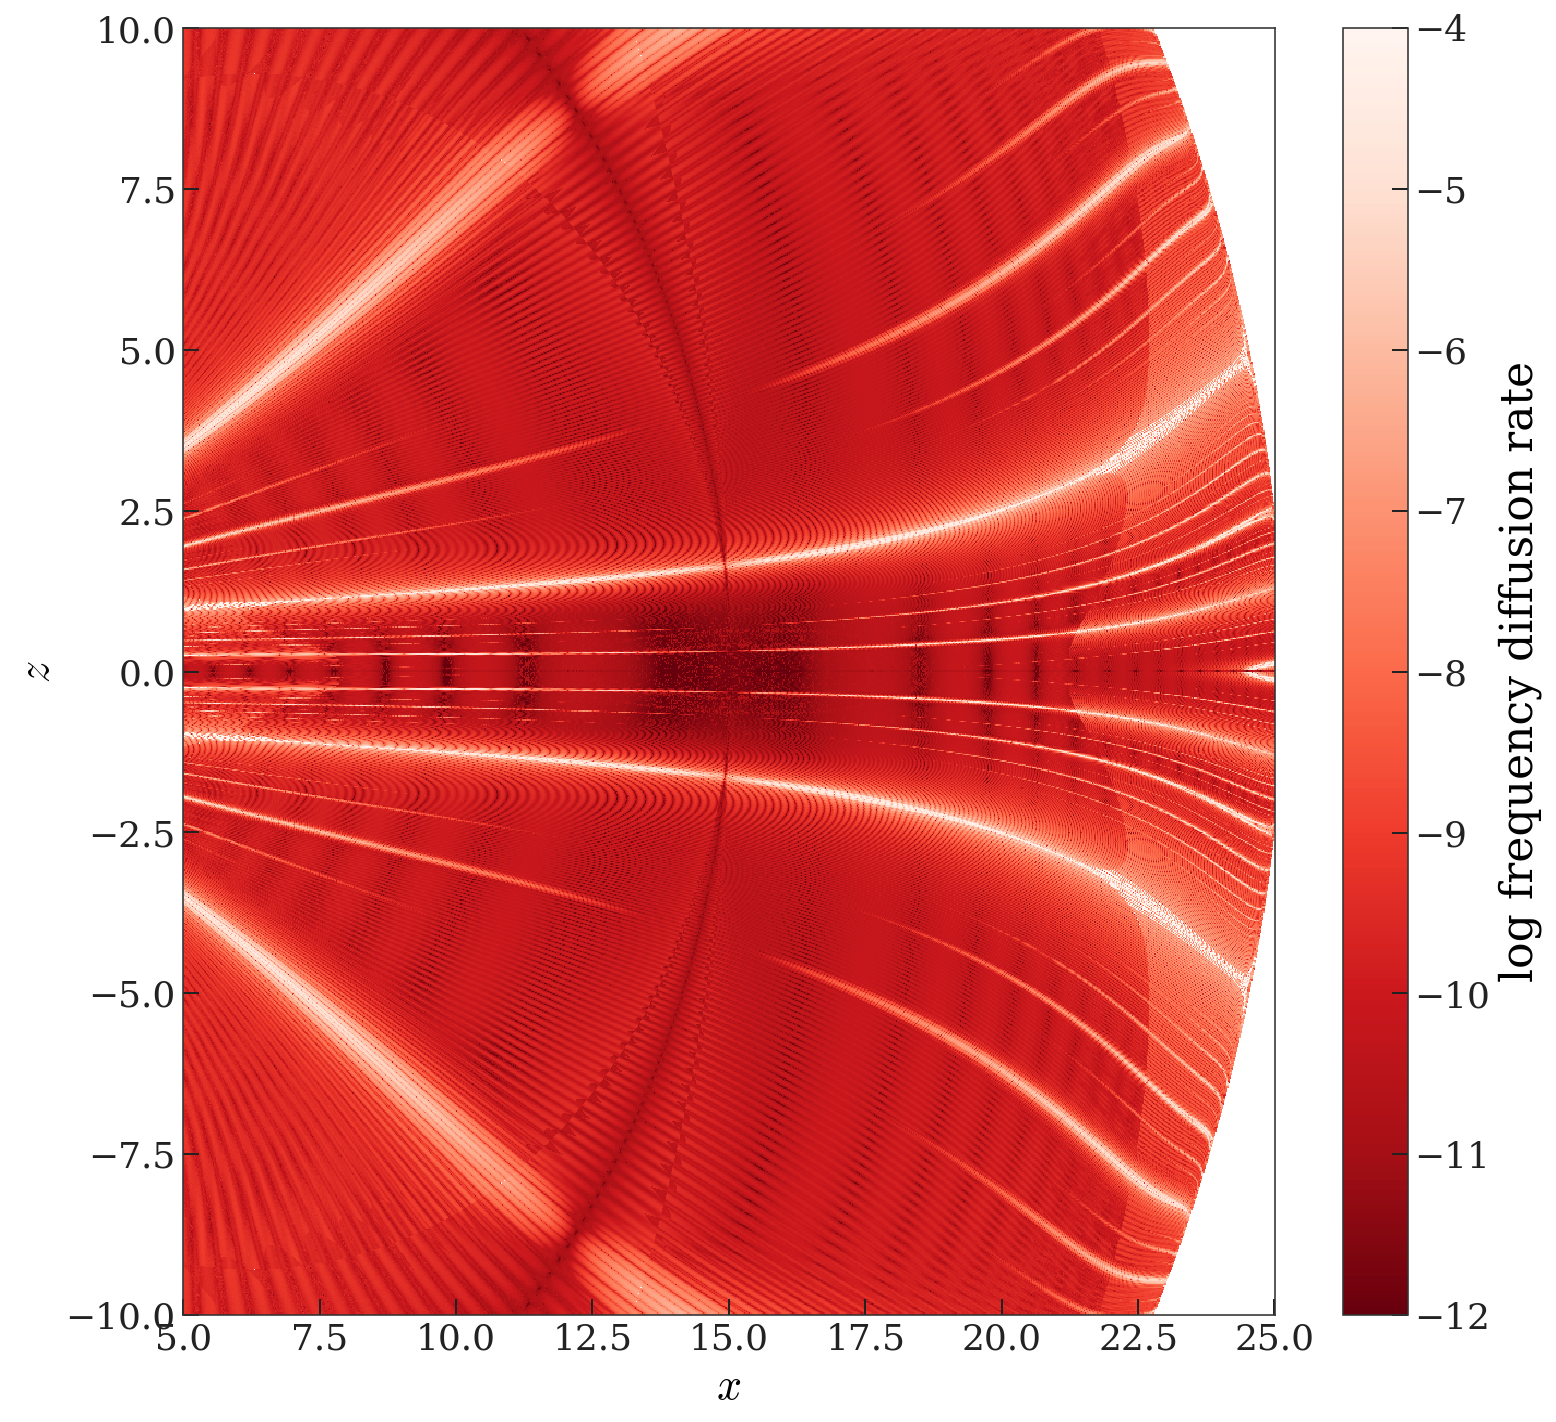

In [299]:
c = np.log10(absfreqdiff.value)

fig, ax = plt.subplots(1, 1, figsize=(11, 10))

c = c.reshape((len(zgrid), len(xgrid)))
for a in [1, -1]:
    cs = ax.pcolormesh(xgrid, a * zgrid, c, 
                       shading='auto', cmap='Reds_r',
                       vmin=-12, vmax=-4)

ax.set_xlabel('$x$')
ax.set_ylabel('$z$')
    
cb = fig.colorbar(cs)
cb.set_label('log frequency diffusion rate')
fig.tight_layout()

# for k, sp in ax.spines.items():
#     sp.set_visible(False)
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# fig.tight_layout()

In [292]:
nvecs = get_nvecs(max_int=8)

In [293]:
abs_nvecdotfreq = np.abs(np.einsum('ij,nj->in', nvecs, tbl['freq1']))

min_abs_nvecdotfreq = abs_nvecdotfreq.min(axis=0)
abs_idx = abs_nvecdotfreq.argmin(axis=0)
abs_idx.shape

(501501,)

In [294]:
len(tbl), len(abs_nvecdotfreq)

(501501, 3434)

In [295]:
index = np.arange(len(tbl))

resonant_idx = []
resonant_nvec = []
for i, nvec in enumerate(nvecs):
    # if np.linalg.norm(nvec) > 8:
    #     continue
    
    if np.any(nvec == 0):
        continue
        j = np.nanargmin(abs_nvecdotfreq[i])
        
    # elif np.allclose(np.abs(nvec[0]), np.abs(nvec)):
#         continue
        
    else:
        _mask = tbl['z'] != 0
        j = np.nanargmin(abs_nvecdotfreq[i][_mask])
        
        if np.abs(abs_nvecdotfreq[i][_mask][j].value) > 1e-6:
            continue
            
        if tuple(-nvec) in [tuple(x) for x in resonant_nvec]:
            continue
        
        resonant_idx.append(index[_mask][j])
        resonant_nvec.append(nvec)
        
        # print(index[_mask][j], nvec, abs_nvecdotfreq[i][_mask][j])
        
resonant_idx = np.array(resonant_idx)
resonant_nvec = np.array(resonant_nvec)
        
len(resonant_idx)

462

In [296]:
plot_path = pathlib.Path('../plots')
plot_path.mkdir(exist_ok=True)

In [297]:
n = 0

html_lines = []

nvec_norm = np.linalg.norm(resonant_nvec, axis=1)
rank = np.argsort(nvec_norm)

for j, nvec in zip(resonant_idx[rank], 
                   resonant_nvec[rank]):
    row = tbl[j]
    w0 = gd.PhaseSpacePosition(
        pos=[row['x'].value, 0, row['z'].value] * u.kpc,
        vel=[0, row['vy'].value, 0] * u.km/u.s)

    x_plot_file = plot_path / f'orbit_{nvec[0]}_{nvec[1]}_{nvec[2]}.png'
    v_plot_file = plot_path / f'orbit-v_{nvec[0]}_{nvec[1]}_{nvec[2]}.png'
    
    html_lines.append(f'<img src="plots/{x_plot_file.name}">')
    html_lines.append(f'<img src="plots/{v_plot_file.name}">')
    
    if x_plot_file.exists() and v_plot_file.exists():
        continue
    
    orbit = H.integrate_orbit(w0, dt=1., n_steps=400_000, 
                              Integrator=gi.DOPRI853Integrator)
    
    if not x_plot_file.exists():
        fig, axes = plt.subplots(1, 3, figsize=(15, 5.2))
        fig = orbit.plot(linestyle='none', marker='o', mew=0, 
                         alpha=0.12, ms=0.8, auto_aspect=False,
                         labels=['$x$', '$y$', '$z$'], axes=axes)
        axes[1].set_title(f'${nvec[0]}:{nvec[1]}:{nvec[2]}$', fontsize=24)
        fig.tight_layout()
        fig.set_facecolor('w')
        fig.savefig(x_plot_file, dpi=250)
        plt.close(fig)
    
    # ---
    
    if not v_plot_file.exists():
        fig, axes = plt.subplots(1, 3, figsize=(15, 5.2))
        fig = orbit.plot(['v_x', 'v_y', 'v_z'], 
                         linestyle='none', marker='o', mew=0, 
                         alpha=0.12, ms=0.8, auto_aspect=False,
                         labels=['$v_x$', '$v_y$', '$_vz$'], axes=axes)
        axes[1].set_title(f'${nvec[0]}:{nvec[1]}:{nvec[2]}$', fontsize=24)
        fig.tight_layout()
        fig.set_facecolor('w')
        fig.savefig(v_plot_file, dpi=250)
        plt.close(fig)

In [298]:
print('\n'.join(html_lines))

<img src="plots/orbit_1_-1_-1.png">
<img src="plots/orbit-v_1_-1_-1.png">
<img src="plots/orbit_-1_-1_1.png">
<img src="plots/orbit-v_-1_-1_1.png">
<img src="plots/orbit_-1_-1_2.png">
<img src="plots/orbit-v_-1_-1_2.png">
<img src="plots/orbit_2_-1_-1.png">
<img src="plots/orbit-v_2_-1_-1.png">
<img src="plots/orbit_1_-1_-2.png">
<img src="plots/orbit-v_1_-1_-2.png">
<img src="plots/orbit_1_-2_1.png">
<img src="plots/orbit-v_1_-2_1.png">
<img src="plots/orbit_-2_-1_2.png">
<img src="plots/orbit-v_-2_-1_2.png">
<img src="plots/orbit_-1_-2_2.png">
<img src="plots/orbit-v_-1_-2_2.png">
<img src="plots/orbit_2_-2_-1.png">
<img src="plots/orbit-v_2_-2_-1.png">
<img src="plots/orbit_1_-2_2.png">
<img src="plots/orbit-v_1_-2_2.png">
<img src="plots/orbit_1_-3_1.png">
<img src="plots/orbit-v_1_-3_1.png">
<img src="plots/orbit_-1_-1_3.png">
<img src="plots/orbit-v_-1_-1_3.png">
<img src="plots/orbit_1_-1_-3.png">
<img src="plots/orbit-v_1_-1_-3.png">
<img src="plots/orbit_2_-3_1.png">
<img src=

In [156]:
np.unique(abs_idx).size

311

In [154]:
log10_diff = np.log10(min_abs_nvecdotfreq.value)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, '$z$')

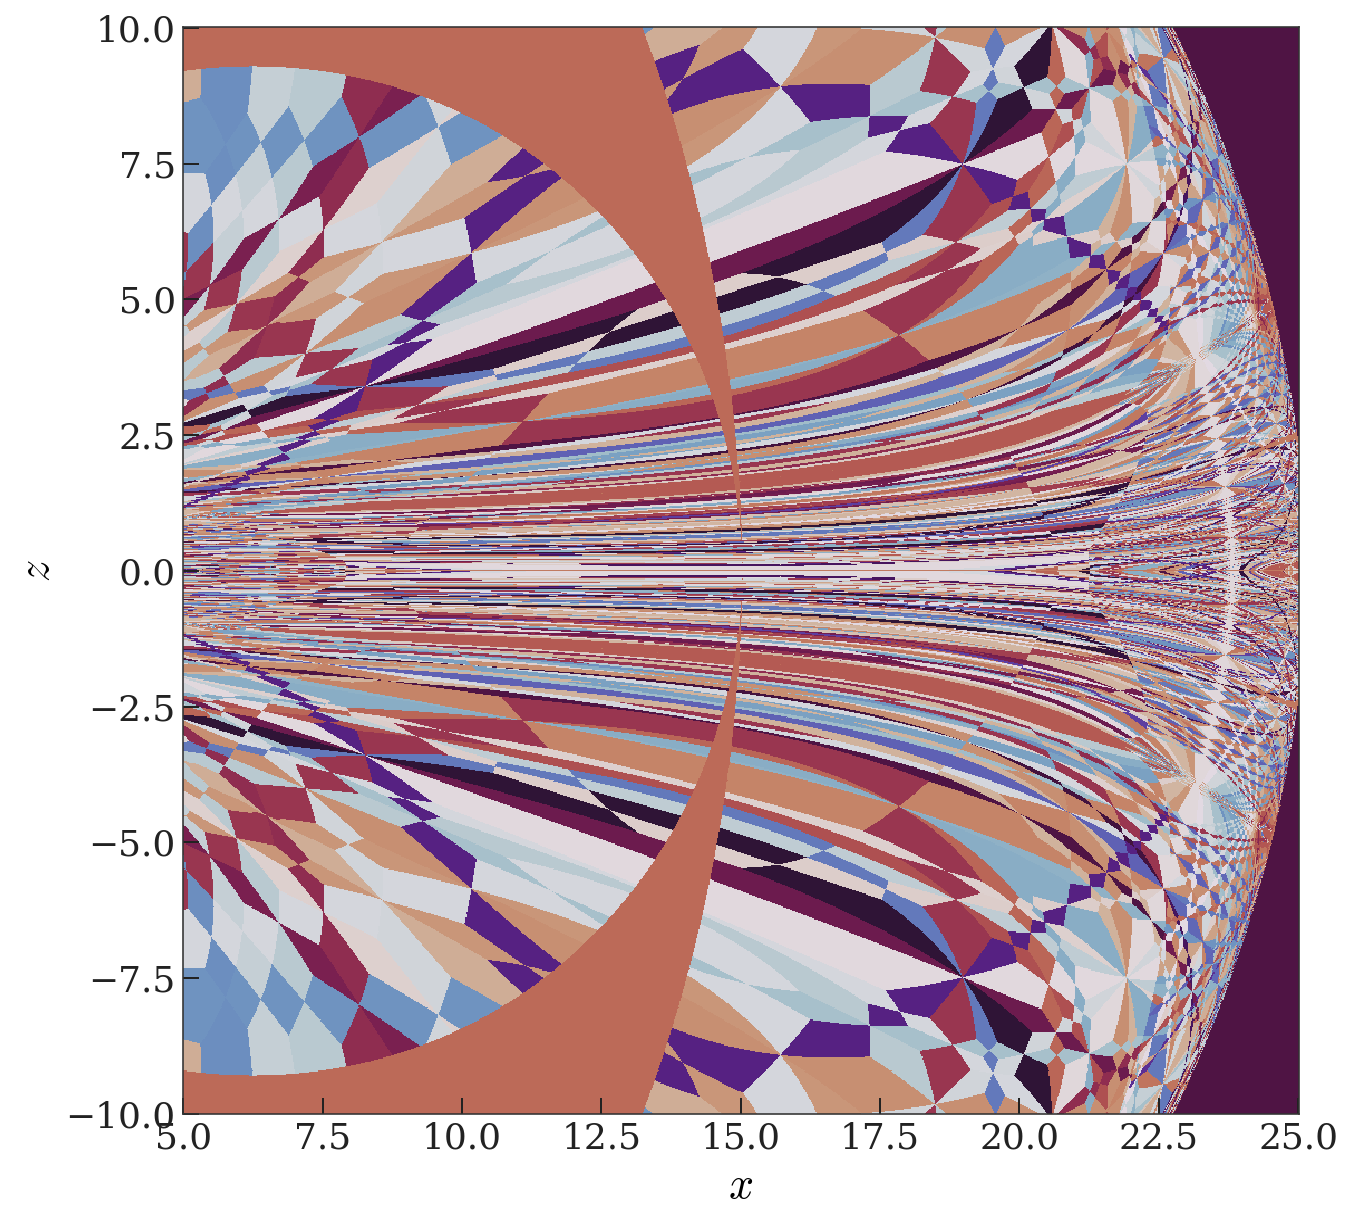

In [301]:
# c = test
c = np.linalg.norm(nvecs, axis=1)[test]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

c = c.reshape((len(zgrid), len(xgrid)))
for a in [1, -1]:
    cs = ax.pcolormesh(xgrid, a * zgrid, c, 
                       shading='auto', cmap='twilight_shifted')

ax.set_xlabel('$x$')
ax.set_ylabel('$z$')
    
# fig.colorbar(cs)

# for k, sp in ax.spines.items():
#     sp.set_visible(False)
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# fig.tight_layout()

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, '$z$')

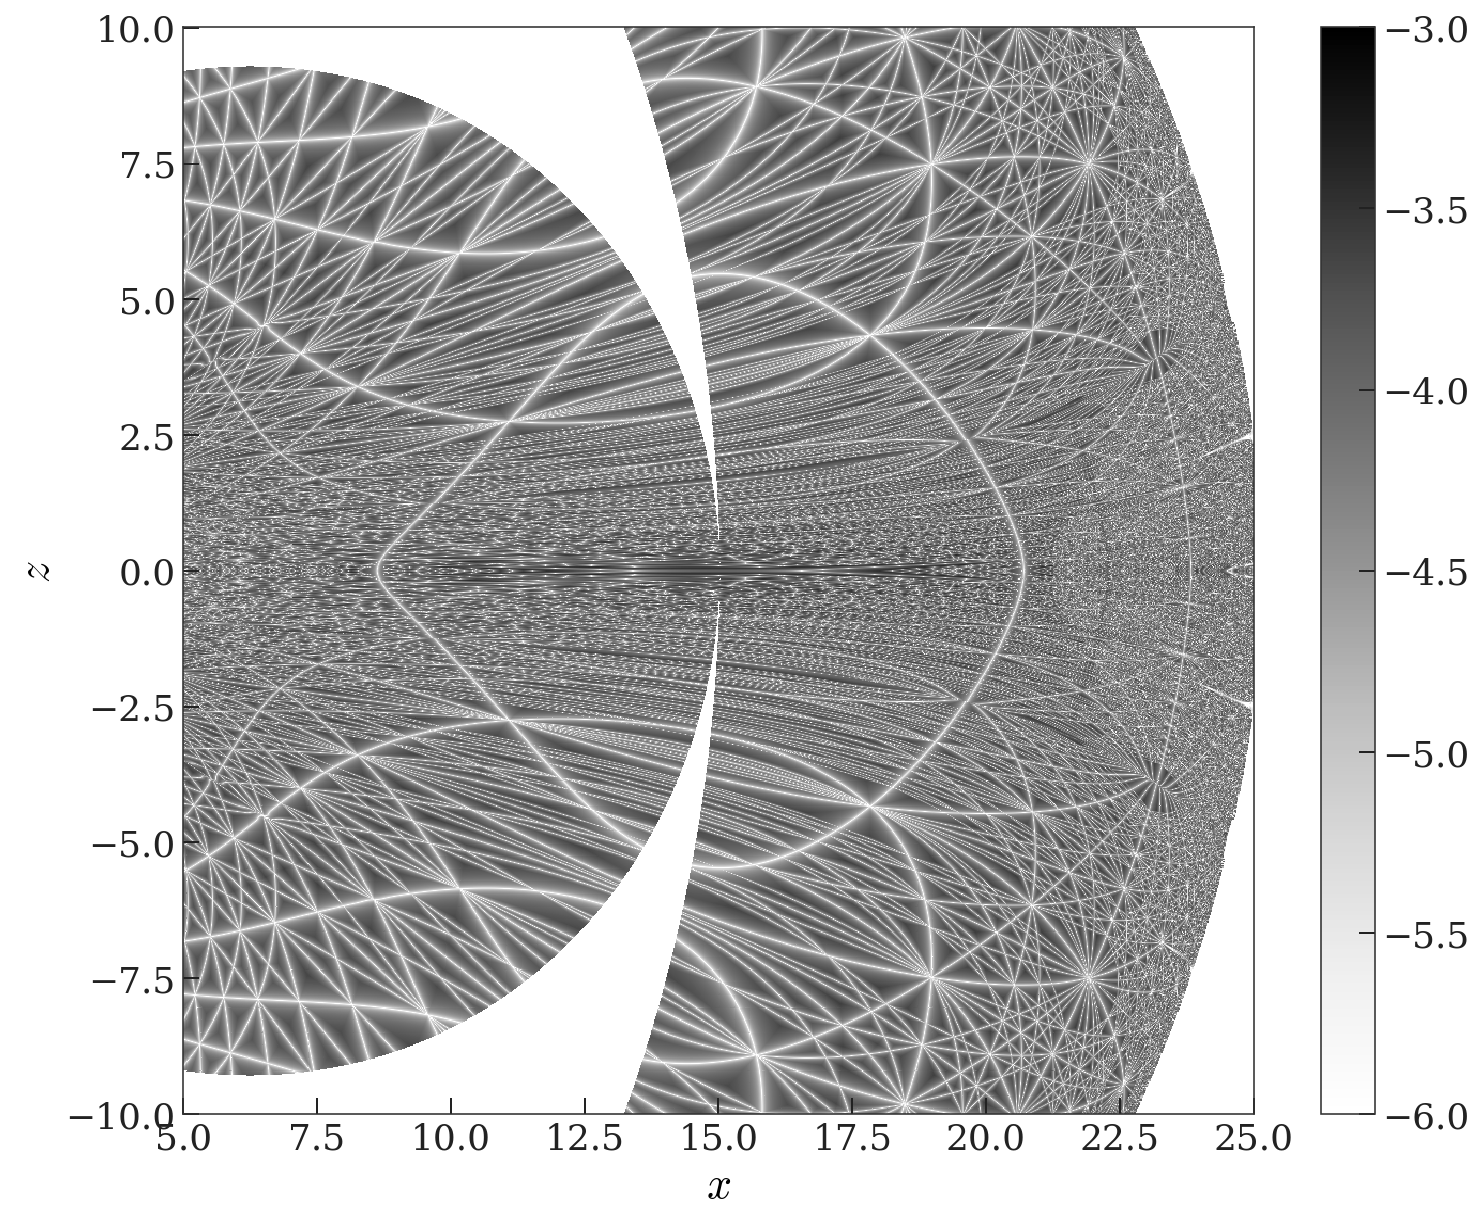

In [302]:
c = np.log10(min_abs_nvecdotfreq.value)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

c = c.reshape((len(zgrid), len(xgrid)))
for a in [1, -1]:
    cs = ax.pcolormesh(xgrid, a * zgrid, c, 
                       shading='auto', cmap='Greys',
                       vmin=-6, vmax=-3)

fig.colorbar(cs)

ax.set_xlabel('$x$')
ax.set_ylabel('$z$')

# for k, sp in ax.spines.items():
#     sp.set_visible(False)
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
# fig.tight_layout()